# F-classify: This Notebook develops and evaluates the NOIRE-Net F-region classification networks

## 1 - Develop NOIRE-Net

### 1.1 - Import libaries 

In [2]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### 1.2 - Define function to get ionogram label (True = F-region, False = No F-region)

In [3]:
# The function get_label_from_par reads a .par file and returns 
# True if either the second or fourth item is not 'nan', 
# indicating the presence of an F-region in the corresponding image,
# for use in binary classification.

def get_label_from_par(par_file_path):
    try:
        # Open the .par file located at par_file_path
        with open(par_file_path, 'r') as file:
            content = file.readline().strip()  # Read and strip the first line of the file
            items = content.split()  # Split the line into individual items (usually numbers or 'nan')

            # Check the first (index 0) and third (index 2) items:
            # If either of these items is not 'nan', it implies the presence of an F-region.
            # The function then returns True, indicating that this image has an F-region.
            is_f_region = items[0].lower() != 'nan' or items[2].lower() != 'nan'
        return is_f_region

    except IndexError:
        # This block catches an IndexError, which occurs if the line read from the file
        # does not have at least four items. In such a case, the function assumes that
        # the F-region data is not present or not properly formatted, and returns False.
        return False

    except Exception as e:
        # This block catches any other exceptions (like file not found, read errors, etc.).
        # It prints the exception message and returns False, indicating an issue with processing the file.
        print(f"Error reading {par_file_path}: {e}")
        return False

### 1.3 - Define function to load ionograms and preprocess the data

In [4]:
# The load_data function loads and preprocesses image data from a specified directory,
# converting images to grayscale and resizing them, while also extracting corresponding
# binary labels from associated .par files for a classification task.

def load_data(data_dir):
    images = []  # List to store preprocessed images
    labels = []  # List to store corresponding labels

    # Construct paths to the directories containing ionograms and parameters
    ionograms_dir = os.path.join(data_dir, 'ionograms')
    parameters_dir = os.path.join(data_dir, 'parameters')

    # Iterate over the files in the ionograms directory
    for filename in os.listdir(ionograms_dir):
        if filename.endswith('.png'):  # Check if the file is a PNG image
            # Construct full paths to the image file and its corresponding .par file
            img_path = os.path.join(ionograms_dir, filename)
            par_path = os.path.join(parameters_dir, filename.replace('.png', '.par'))

            # Load the image, convert it to grayscale, resize it, and normalize pixel values
            image = load_img(img_path, color_mode='grayscale', target_size=(310, 310))
            image = img_to_array(image)
            image /= 255.0  # Normalize image pixels to be between 0 and 1

            # Load the label for the image using the get_label_from_par function
            label = get_label_from_par(par_path)

            # Append the preprocessed image and label to their respective lists
            images.append(image)
            labels.append(label)

    # Convert the lists of images and labels to numpy arrays and return them
    return np.array(images), np.array(labels).astype(int)

### 1.4 - Load the ionograms and labels from the data folder 

In [5]:
# Specify the directory where the data is stored
data_dir = 'train-val'  # 'train_test_val' should be replaced with the actual path to your data directory

# Call the load_data function to load and preprocess the data
# X wildsdsdl contain the preprocessed images, and y will contain the corresponding labels
X, y = load_data(data_dir)

### 1.5 - Define a function to create the NOIRE-Net architecture

In [6]:
# This code defines and complies NOIRE-Net a convolutional neural network (CNN) model using Keras, 
# with multiple convolutional layers, batch normalization, max pooling, and dense layers, 
# designed for binary classification tasks.

def NOIREnet():
    model = Sequential([
    # First convolutional layer with 32 filters and a kernel size of 3x3
    # 'padding=same' ensures the output size is the same as the input size
    # 'input_shape' is set for the first layer to indicate the shape of the input data
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(310, 310, 1)),
    
    # Batch normalization to normalize the activations from the previous layer
    BatchNormalization(),

    # Second convolutional layer with 32 filters and a kernel size of 3x3
    Conv2D(32, (3, 3), activation='relu'),

    # Another batch normalization
    BatchNormalization(),

    # First max pooling layer to reduce spatial dimensions
    MaxPooling2D((2, 2)),

    # Repeating the pattern of two convolutional layers followed by batch normalization
    # and a max pooling layer, gradually increasing the number of filters
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten the output from the convolutional layers to feed into dense layers
    Flatten(),

    # Dense (fully connected) layer with 256 neurons and relu activation
    Dense(256, activation='relu'),

    # Dropout layer to reduce overfitting
    Dropout(0.5),

    # Another dense layer with 128 neurons
    Dense(128, activation='relu'),

    # Output layer with a single neuron and sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
    ])
    
    # Compile the CNN model
    model.compile(
        optimizer='adam',  # Using the Adam optimizer for adaptive learning rate optimization
        loss='binary_crossentropy',  # Binary crossentropy loss function, suitable for binary classification tasks
        metrics=['accuracy']  # The model will report 'accuracy' as a performance metric
    )
    
    # Return the compiled model
    return model

### 1.6 - Train 10 CNNs for F-region classification and save the models

In [7]:
# This code trains 10 Convolutional Neural Networks (CNNs) on differently split subsets
# of a dataset for binary classification,saves the best model of each training session, 
# and records their training histories.

import os
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Create the directory for saving models and histories if it doesn't exist
save_dir = 'F-classify'
os.makedirs(save_dir, exist_ok=True)

# Initialize lists to store the training histories and filenames of the best models
histories = []
model_filenames = []

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,      # Factor to reduce the learning rate
    patience=10,     # Number of epochs with no improvement to wait before reducing LR
    min_lr=0.00001   # Minimum learning rate
)

# Loop to train 10 CNN models with different data splits
for i in range(10):
    # Split the dataset into training and validation sets with stratification
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)
    
    # Create a new CNN model for each iteration
    model = NOIREnet()

    # Define the filename for the checkpoint model
    model_filename = os.path.join(save_dir, f'F-label_run{i+1}.h5')

    # Define a checkpoint callback to save the best model based on validation accuracy
    checkpoint_callback = ModelCheckpoint(
        model_filename,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max',
        save_weights_only=False
    )

    # Train the model with specified callbacks including ReduceLROnPlateau
    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_callback, reduce_lr]  # Include ReduceLROnPlateau callback
    )

    # Save the training history and the filename of the saved best model
    histories.append(history.history)
    model_filenames.append(model_filename)

# Optionally, save the training histories to a file in the same 'F-classify' directory
history_filename = os.path.join(save_dir, 'training_histories.pkl')
with open(history_filename, 'wb') as file:
    pickle.dump({'histories': histories, 'model_filenames': model_filenames}, file)


Metal device set to: Apple M1 Max


2023-11-28 21:41:18.012825: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-28 21:41:18.012994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2023-11-28 21:41:20.395164: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-28 21:41:21.221335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be

144/145 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9143

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9143

2023-11-28 21:42:16.834544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run1.h5
145/145 [==============================] - 60s 370ms/step - loss: 0.2297 - accuracy: 0.9143 - val_loss: 3.0256 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9278
Epoch 2: val_accuracy did not improve from 0.46503
145/145 [==============================] - 51s 351ms/step - loss: 0.1872 - accuracy: 0.9278 - val_loss: 1.6828 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9332
Epoch 3: val_accuracy improved from 0.46503 to 0.47150, saving model to F-classify/F-label_run1.h5
145/145 [==============================] - 52s 358ms/step - loss: 0.1741 - accuracy: 0.9332 - val_loss: 1.4076 - val_accuracy: 0.4715 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9324
Epoch 4: val_accuracy improved from 0.47150 to 0.89810, saving model to F-classify/F-label_run1.h5
145/145 [==============================] - 51s 350ms/step - loss: 0.1703 - accuracy: 0.9324 - val_loss: 0.2513 - val_accuracy: 0.8981 - lr: 0.0010
Epoch 5/30
145/145 [=============

2023-11-28 22:06:28.041575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2338 - accuracy: 0.9143

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9143

2023-11-28 22:07:15.362623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run2.h5
145/145 [==============================] - 52s 339ms/step - loss: 0.2336 - accuracy: 0.9143 - val_loss: 3.2933 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9279
Epoch 2: val_accuracy improved from 0.46503 to 0.53497, saving model to F-classify/F-label_run2.h5
145/145 [==============================] - 49s 341ms/step - loss: 0.1836 - accuracy: 0.9279 - val_loss: 0.7498 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9309
Epoch 3: val_accuracy did not improve from 0.53497
145/145 [==============================] - 49s 338ms/step - loss: 0.1788 - accuracy: 0.9309 - val_loss: 0.7336 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9335
Epoch 4: val_accuracy improved from 0.53497 to 0.83679, saving model to F-classify/F-label_run2.h5
145/145 [==============================] - 50s 343ms/step - loss: 0.1631 - accuracy: 0.9335 - val_loss: 0.5253 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 5/30
145/145 [=============

2023-11-28 22:31:08.529879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2333 - accuracy: 0.9104

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9101

2023-11-28 22:32:07.506826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run3.h5
145/145 [==============================] - 69s 459ms/step - loss: 0.2337 - accuracy: 0.9101 - val_loss: 1.1118 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9246
Epoch 2: val_accuracy did not improve from 0.46503
145/145 [==============================] - 70s 480ms/step - loss: 0.1927 - accuracy: 0.9246 - val_loss: 1.2196 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9293
Epoch 3: val_accuracy improved from 0.46503 to 0.49180, saving model to F-classify/F-label_run3.h5
145/145 [==============================] - 71s 490ms/step - loss: 0.1795 - accuracy: 0.9293 - val_loss: 1.0733 - val_accuracy: 0.4918 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9332
Epoch 4: val_accuracy improved from 0.49180 to 0.88472, saving model to F-classify/F-label_run3.h5
145/145 [==============================] - 70s 482ms/step - loss: 0.1650 - accuracy: 0.9332 - val_loss: 0.4183 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 5/30
145/145 [=============

2023-11-28 23:06:52.033130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2308 - accuracy: 0.9103

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9101

2023-11-28 23:07:40.033439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run4.h5
145/145 [==============================] - 55s 344ms/step - loss: 0.2308 - accuracy: 0.9101 - val_loss: 2.3559 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9298
Epoch 2: val_accuracy did not improve from 0.46503
145/145 [==============================] - 50s 345ms/step - loss: 0.1859 - accuracy: 0.9298 - val_loss: 1.4771 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9281
Epoch 3: val_accuracy improved from 0.46503 to 0.46589, saving model to F-classify/F-label_run4.h5
145/145 [==============================] - 51s 351ms/step - loss: 0.1783 - accuracy: 0.9281 - val_loss: 0.8110 - val_accuracy: 0.4659 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9324
Epoch 4: val_accuracy improved from 0.46589 to 0.72064, saving model to F-classify/F-label_run4.h5
145/145 [==============================] - 51s 349ms/step - loss: 0.1660 - accuracy: 0.9324 - val_loss: 0.9247 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 5/30
145/145 [=============

2023-11-28 23:32:03.394025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2310 - accuracy: 0.9138

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9141

2023-11-28 23:33:05.161068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run5.h5
145/145 [==============================] - 66s 441ms/step - loss: 0.2304 - accuracy: 0.9141 - val_loss: 1.1987 - val_accuracy: 0.4650 - lr: 0.0010


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9271
Epoch 2: val_accuracy did not improve from 0.46503
145/145 [==============================] - 51s 349ms/step - loss: 0.1867 - accuracy: 0.9271 - val_loss: 3.3712 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9306
Epoch 3: val_accuracy improved from 0.46503 to 0.52979, saving model to F-classify/F-label_run5.h5
145/145 [==============================] - 51s 350ms/step - loss: 0.1723 - accuracy: 0.9306 - val_loss: 0.8106 - val_accuracy: 0.5298 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9310
Epoch 4: val_accuracy improved from 0.52979 to 0.67617, saving model to F-classify/F-label_run5.h5
145/145 [==============================] - 51s 351ms/step - loss: 0.1671 - accuracy: 0.9310 - val_loss: 0.6227 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 5/30
145/145 [==

2023-11-28 23:57:18.580166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2372 - accuracy: 0.9102

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9103

2023-11-28 23:58:18.948952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run6.h5
145/145 [==============================] - 70s 466ms/step - loss: 0.2368 - accuracy: 0.9103 - val_loss: 2.0283 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1892 - accuracy: 0.9265
Epoch 2: val_accuracy improved from 0.46503 to 0.53497, saving model to F-classify/F-label_run6.h5
145/145 [==============================] - 72s 499ms/step - loss: 0.1892 - accuracy: 0.9265 - val_loss: 0.7104 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9317
Epoch 3: val_accuracy improved from 0.53497 to 0.57254, saving model to F-classify/F-label_run6.h5
145/145 [==============================] - 71s 492ms/step - loss: 0.1707 - accuracy: 0.9317 - val_loss: 0.7009 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9331
Epoch 4: val_accuracy improved from 0.57254 to 0.71503, saving model to F-classify/F-label_run6.h5
145/145 [==============================] - 71s 487ms/step - loss: 0.1641 - accuracy: 0.9331 - val_loss: 0.4563 - val_accuracy: 0.715

2023-11-29 00:32:43.526041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2302 - accuracy: 0.9138

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9137

2023-11-29 00:33:30.134186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run7.h5


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - 53s 332ms/step - loss: 0.2308 - accuracy: 0.9137 - val_loss: 1.4988 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9254
Epoch 2: val_accuracy did not improve from 0.46503
145/145 [==============================] - 47s 324ms/step - loss: 0.1876 - accuracy: 0.9254 - val_loss: 0.7807 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9324
Epoch 3: val_accuracy did not improve from 0.46503
145/145 [==============================] - 47s 324ms/step - loss: 0.1739 - accuracy: 0.9324 - val_loss: 1.0465 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9352
Epoch 4: val_accuracy improved from 0.46503 to 0.54577, saving model to F-classify/F-label_run7.h5
145/145 [==============================] - 47s 324ms/step - loss: 0.16

2023-11-29 00:56:31.546736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.9100

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9103

2023-11-29 00:57:34.691428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run8.h5
145/145 [==============================] - 68s 446ms/step - loss: 0.2383 - accuracy: 0.9103 - val_loss: 4.7526 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9233
Epoch 2: val_accuracy did not improve from 0.46503
145/145 [==============================] - 49s 337ms/step - loss: 0.1918 - accuracy: 0.9233 - val_loss: 0.8149 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9274
Epoch 3: val_accuracy improved from 0.46503 to 0.59974, saving model to F-classify/F-label_run8.h5
145/145 [==============================] - 50s 341ms/step - loss: 0.1757 - accuracy: 0.9274 - val_loss: 0.6773 - val_accuracy: 0.5997 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9309
Epoch 4: val_accuracy improved from 0.59974 to 0.70207, saving model to F-classify/F-label_run8.h5
145/145 [==============================] - 49s 340ms/step - loss: 0.1710 - accuracy: 0.9309 - val_loss: 0.5676 - val_accuracy: 0.7021 - lr: 0.0010
Epoch 5/30
145/145 [=============

2023-11-29 01:21:18.427387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2418 - accuracy: 0.9082

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9084

2023-11-29 01:22:22.122049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run9.h5


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - 74s 491ms/step - loss: 0.2412 - accuracy: 0.9084 - val_loss: 2.0855 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9240
Epoch 2: val_accuracy improved from 0.46503 to 0.53497, saving model to F-classify/F-label_run9.h5
145/145 [==============================] - 73s 502ms/step - loss: 0.1915 - accuracy: 0.9240 - val_loss: 1.8344 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9270
Epoch 3: val_accuracy did not improve from 0.53497
145/145 [==============================] - 72s 499ms/step - loss: 0.1764 - accuracy: 0.9270 - val_loss: 2.0148 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9295
Epoch 4: val_accuracy improved from 0.53497 to 0.90544, saving model to F-classify/F-label_run9.h5
145/145 [=============

2023-11-29 01:57:09.879949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2379 - accuracy: 0.9089

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9090

2023-11-29 01:57:57.909316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.46503, saving model to F-classify/F-label_run10.h5
145/145 [==============================] - 55s 339ms/step - loss: 0.2373 - accuracy: 0.9090 - val_loss: 3.0257 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.9233
Epoch 2: val_accuracy did not improve from 0.46503
145/145 [==============================] - 49s 333ms/step - loss: 0.1889 - accuracy: 0.9233 - val_loss: 2.6832 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9276
Epoch 3: val_accuracy improved from 0.46503 to 0.47798, saving model to F-classify/F-label_run10.h5
145/145 [==============================] - 49s 340ms/step - loss: 0.1763 - accuracy: 0.9276 - val_loss: 1.2174 - val_accuracy: 0.4780 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9318
Epoch 4: val_accuracy improved from 0.47798 to 0.83808, saving model to F-classify/F-label_run10.h5
145/145 [==============================] - 50s 343ms/step - loss: 0.1681 - accuracy: 0.9318 - val_loss: 0.3761 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 5/30
145/145 [===========

## 2 - Test the performance of NOIRE-Net on an independent test set

### 2.1 - Define a function to get ionogram labels from the testing data 

In [9]:
# This code defines the get_majority_label function which determines the majority label 
# (True or False) among a list of .par files, and in case of a tie, it randomly selects a label.
def get_majority_label(par_files):
    # Extract labels from each .par file using the get_label_from_par function
    labels = [get_label_from_par(f) for f in par_files]

    # If the majority of labels are True, return True
    if labels.count(True) > len(labels) / 2:
        return True
    # If the majority of labels are False, return False
    elif labels.count(False) > len(labels) / 2:
        return False
    # If there is a tie between True and False labels, randomly choose one
    else:
        return random.choice([True, False])  # Randomize in case of a tie

### 2.2 - Define a function to load and process test images

In [10]:
# This code defines the load_and_preprocess_image function, which loads an image from a 
# specified path, converts it to grayscale, resizes it to 310x310 pixels, normalizes its pixel
# values, and returns the processed image as an array.
def load_and_preprocess_image(image_path):
    # Load the image from the given path, convert it to grayscale, and resize it to 310x310 pixels
    image = load_img(image_path, color_mode='grayscale', target_size=(310, 310))

    # Convert the image to a numpy array
    image = img_to_array(image)

    # Normalize the pixel values to be in the range [0, 1]
    image /= 255.0

    # Return the preprocessed image
    return image

### 2.3 - Load the trained models with the highest validation accuracy 

In [11]:
# Define function to load models
def load_models(models_dir):
    return [load_model(os.path.join(models_dir, mf)) for mf in os.listdir(models_dir) if mf.endswith('.h5')]

# Specify the directory where the trained models are stored
models_dir = 'F-classify'

# Load the models
models = load_models(models_dir)

### 2.4 - Define a function to prepare the resting data for comparison with CNNs

In [12]:
# This function prepares the testing dataset by loading and processing images from a 
# specified directory and determining corresponding human labels based on majority voting
# from associated .par files.
def prepare_test_data(ionograms_dir, parameters_dir):
    X_test = []  # List to store preprocessed images
    y_human = []  # List to store corresponding human labels

    # Cache the paths of all .par files for efficient access
    par_files_cache = {f: os.path.join(parameters_dir, f) for f in os.listdir(parameters_dir)}

    # Iterate through each image file in the ionograms directory
    for img_file in os.listdir(ionograms_dir):
        if img_file.endswith('.png'):  # Only process .png files
            img_path = os.path.join(ionograms_dir, img_file)
            X_test.append(load_and_preprocess_image(img_path))  # Load and preprocess the image

            # Extract timestamp from the image filename
            timestamp = os.path.splitext(img_file)[0]

            # Get all .par files relevant to the current image based on timestamp
            relevant_par_files = [fpath for fname, fpath in par_files_cache.items() if timestamp in fname]
            y_human.append(get_majority_label(relevant_par_files))  # Determine the majority label

    # Convert lists to numpy arrays
    return np.array(X_test), np.array(y_human).astype(int)

### 2.5 - Define a function compare the CNN predictions to the human labeling

In [13]:
# This function evaluates a list of pre-loaded CNN models on a prepared test dataset, calculates key
# performance metrics (precision, recall, F1-score, accuracy), prints their mean and standard deviation,
# and returns the normalized confusion matrices for each model.
def evaluate_models(models, X_test, y_human):
    metrics = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}  # Dictionary to store metrics for each model
    confusion_matrices = []  # List to store confusion matrices for each model

    # Iterate over each model and evaluate it
    for model in models:
        y_pred = model.predict(X_test).round().astype(int)  # Predict labels for the test dataset

        # Calculate and store the performance metrics for the current model
        metrics['precision'].append(precision_score(y_human, y_pred))
        metrics['recall'].append(recall_score(y_human, y_pred))
        metrics['f1'].append(f1_score(y_human, y_pred))
        metrics['accuracy'].append(accuracy_score(y_human, y_pred))

        # Calculate and store the normalized confusion matrix
        confusion_matrices.append(confusion_matrix(y_human, y_pred, normalize='true'))

    # Print the mean and standard deviation for each metric
    for metric, values in metrics.items():
        print(f"Mean {metric.capitalize()}: {np.mean(values):.3f}, Std {metric.capitalize()}: {np.std(values):.3f}")

    return confusion_matrices

### 2.6 - Specify testing directories and prepare testing data

In [14]:
# Specify the directory where the testing data is located
testing_dir = 'testing'

# Specify the directory where the input ionograms are located
ionograms_dir = os.path.join(testing_dir, 'ionograms')

# Specify the directory where the output parameters are located
parameters_dir = os.path.join(testing_dir, 'parameters')

# Load and prepare the testing data
X_test, y_human = prepare_test_data(ionograms_dir, parameters_dir)

### 2.7 - Evaluate the models using precision, recall, F1-score, accuracy

In [15]:
# Evaluate the models located in 'models_dir' using the test data in 'testing_dir'
# and store the returned confusion matrices
confusion_matrices = evaluate_models(models, X_test, y_human)

2023-11-29 11:11:12.194425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 3s 89ms/step


2023-11-29 11:11:15.003714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 47ms/step


2023-11-29 11:11:16.458618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 52ms/step


2023-11-29 11:11:18.004598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 50ms/step


2023-11-29 11:11:19.502943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 48ms/step


2023-11-29 11:11:21.058100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 55ms/step


2023-11-29 11:11:22.788179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 60ms/step


2023-11-29 11:11:24.842250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 49ms/step


2023-11-29 11:11:26.724629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 62ms/step


2023-11-29 11:11:28.596986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 57ms/step
Mean Precision: 0.958, Std Precision: 0.014
Mean Recall: 0.962, Std Recall: 0.021
Mean F1: 0.959, Std F1: 0.004
Mean Accuracy: 0.954, Std Accuracy: 0.004


### 2.8 - Calculate the mean and standard deviation of TP, FN, FP and TN

In [16]:
# Convert list of confusion matrices to a 3D NumPy array for easier calculations
confusion_matrices = np.array(confusion_matrices)

# Calculate mean and standard deviation for TP, FN, FP, TN
mean_tp = np.mean(confusion_matrices[:, 1, 1])
std_tp = np.std(confusion_matrices[:, 1, 1])

mean_fn = np.mean(confusion_matrices[:, 1, 0])
std_fn = np.std(confusion_matrices[:, 1, 0])

mean_fp = np.mean(confusion_matrices[:, 0, 1])
std_fp = np.std(confusion_matrices[:, 0, 1])

mean_tn = np.mean(confusion_matrices[:, 0, 0])
std_tn = np.std(confusion_matrices[:, 0, 0])

# Metrics, means, and standard deviations
means = [mean_tp, mean_fn, mean_fp, mean_tn]
std_devs = [std_tp, std_fn, std_fp, std_tn]

## 3 - Display the confusion matrix 

### 3.1 - Define Function for Text Color Based on Background

In [17]:
# This function determines the text color (black or white) based on the background color's
# luminance for better readability.
def text_color_based_on_bg(bg_color):
    # Calculate the perceptual luminance of the color
    luminance = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
    return 'white' if luminance < 0.5 else 'black'

### 3.2 - Plot the Confusion Matrix Statistics

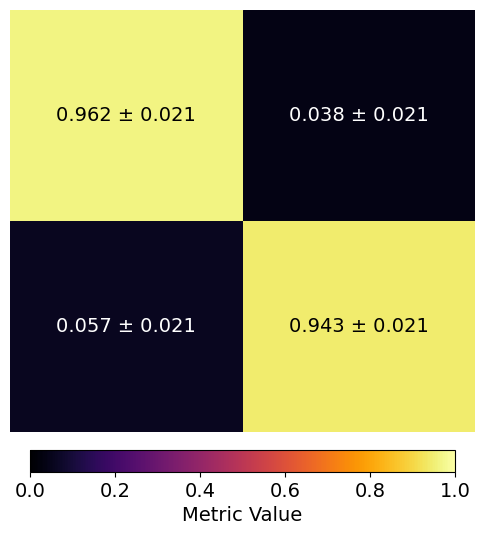

In [18]:
# This code creates a 2x2 plot with colored squares representing the mean and standard 
# deviation of TP, FN, FP, and TN from the confusion matrices.

# Setup color map with normalization between 0 and 1
cmap = plt.cm.inferno
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create a 2x2 subplot figure with adjusted spacing
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()

means = [mean_tp, mean_fn, mean_fp, mean_tn]
std_devs = [std_tp, std_fn, std_fp, std_tn]

# Iterate over each subplot to add the confusion matrix data
for i, ax in enumerate(axs):
    color = cmap(norm(means[i]))  # Set the color based on the mean value
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))  # Create a colored square

    text_color = text_color_based_on_bg(color)  # Determine text color
    text = f'{means[i]:.3f} ± {std_devs[i]:.3f}'  # Format text for mean ± std deviation
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=14, color=text_color)  # Add text to the subplot

    ax.axis('off')  # Remove axes

# Adjust subplot parameters so squares touch each other
plt.subplots_adjust(wspace=0, hspace=0)

# Add a colorbar and adjust its font size
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Metric Value', fontsize=14)
cbar.ax.tick_params(labelsize=14)  # Set font size for colorbar ticks

plt.show()